<a href="https://colab.research.google.com/github/lorocks/A-_Algorithm/blob/main/Project3_Phase2_Part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Thinking

if map is 6000 x 2000 but radius is almost 200

so if i instead of putting threshold reduce the pixels to imply that each pixel is the threshold and actual float value is saved in visited or some other list before using in gazebo, but no need actual pixel for visualize cause screw accuracy am i right

# Setup

In [ ]:
from queue import PriorityQueue
import matplotlib.pyplot as plt
import numpy as np
import cv2
import imutils
import time
import os
import math

from google.colab.patches import cv2_imshow

In [ ]:
def createGrid(height, width, bounding_location, padding = 0, wall_padding = 0, travel_padding = 0, scale = 1):
  doPadding = False
  image = np.full((height, width, 3), 255, dtype=np.uint8)

  if travel_padding > 0:
    image = setTravelPadding(image, travel_padding, bounding_location, scale, 180)

  # if wall_padding > 0 and travel_padding > 0:
  #   image = setWallPadding(image, travel_padding, 180)
  if wall_padding > 0:
    image = setWallPadding(image, wall_padding, 125)

  # if padding > 0 and travel_padding > 0:
  #   image = setObstaclesAndTruePadding(image, bounding_location, travel_padding, scale, 180)
  if padding > 0:
    image = setObstaclesAndTruePadding(image, bounding_location, padding, scale, 125)

  # image_show = cv2.flip(image, 0)
  # cv2_imshow(image_show)
  # print(image_show.shape)

  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  # cv2_imshow(gray)

  grid = np.full((height, width), 5 * height * width)
  grid[gray == 125] = -12
  grid[gray == 180] = -15
  grid[gray == 0] = -11
  # grid = grid.reshape(-1)
  grid = grid.flatten()

  return grid, image

In [ ]:
def setTravelPadding(image, padding, obstacles, scale, value):
  for obstacle in obstacles:
    obstacle = np.array(obstacle, dtype=np.int32) * scale
    obstacle = obstacle.astype(np.int32)
    for point in obstacle: # Check it later
      if len(point) == 3:
        continue
      cv2.circle(image, point, padding, (value, value, value), -1)

  return image

In [ ]:
def setWallPadding(image, padding, value):
  height, width, _ = image.shape

  points = [
      (0, 0), (padding, height),
      (0, 0), (width, padding),
      (0, height - padding), (width, height),
      (width - padding, 0), (width, height),
  ]

  for i in range(0, len(points), 2):
    cv2.rectangle(image, points[i], points[i+1], (value, value, value), -1)

  return image


In [ ]:
def setObstaclesAndTruePadding(image, bounding_location, padding, scale, value):
  if padding > 0:
    doPadding = True

  for obstacle in bounding_location:
    obstacle = np.array(obstacle, dtype=np.int32) * scale
    obstacle = obstacle.astype(np.int32)
    if len(obstacle) == 1: # Check again later
      cv2.circle(image, (obstacle[0][0], obstacle[0][1]), obstacle[0][2] + padding, (value, value, value), -1)
      cv2.circle(image, (obstacle[0][0], obstacle[0][1]), obstacle[0][2], (0, 0, 0), -1)
    else:
      if doPadding:
        x_small = x_big = y_small = y_big = -1
        for point in obstacle:
          if x_small > point[0] or x_small == -1:
            x_small = point[0]
          if x_big < point[0] or x_big == -1:
            x_big = point[0]
          if y_small > point[1] or y_small == -1:
            y_small = point[1]
          if y_big < point[1] or y_big == -1:
            y_big = point[1]
          cv2.circle(image, tuple((np.array(point))), padding, (value, value, value), -1)

        if x_small - padding > 0:
          x_small -= padding
        else:
          x_small = 0
        if x_big + padding < width:
          x_big += padding
        else:
          x_big = width
        if y_small - padding > 0:
          y_small -= padding
        else:
          y_small = 0
        if y_big + padding < height:
          y_big += padding
        else:
          y_big = height
        new_points = np.array([[x_small, y_small], [x_small, y_big], [x_big, y_big], [x_big, y_small]])
        cv2.fillPoly(image, pts=[new_points], color=(value, value, value))

        for point in obstacle:
          cv2.circle(image, tuple((np.array(point))), padding, (value, value, value), -1)
      cv2.fillPoly(image, pts=[obstacle], color=(0, 0, 0))

  return image

In [ ]:
def heuristic(node, goal):
    return math.sqrt((node[0] - goal[0])**2 + (node[1] - goal[1])**2)

def goal_reached(node, goal, threshold):
    if len(node) < 2 or len(goal) < 2:
        raise ValueError("node and goal must be sequences with at least two elements each")
    return heuristic(node, goal) <= threshold

# Implementation

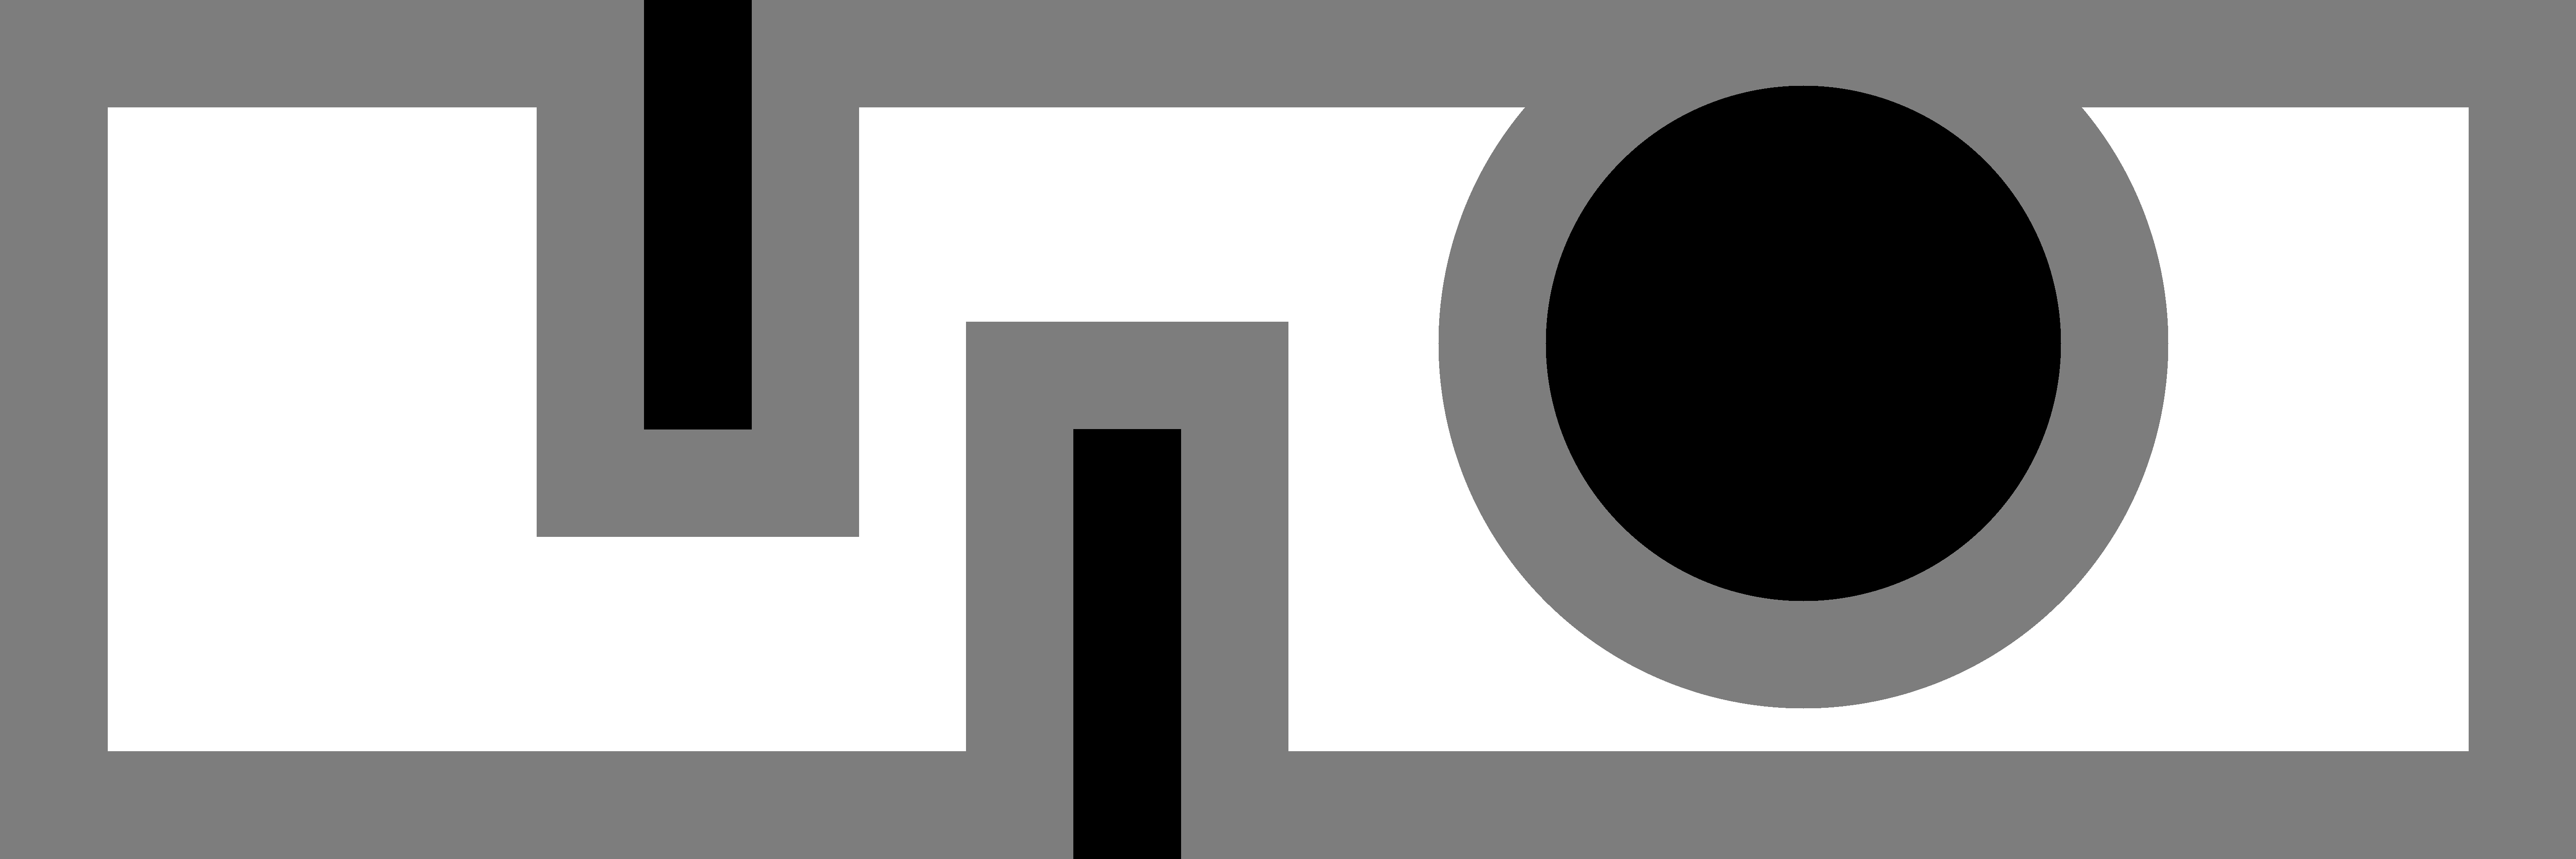

In [ ]:
height = 2000
width = 6000

scale = 1

scaled_height = int(height * scale)
scaled_width = int(width * scale)

effective_padding = math.ceil(250 * scale)
padding = math.ceil(12 * scale)

obstacle_bounding_boxes = [
    [(1500, 2000), (1500, 1000), (1750, 1000),  (1750, 2000)],
    [(2500, 1000), (2500, 0), (2750, 0), (2750, 1000)],
    [(4200, 1200, 600)],
    ]

grid, useless = createGrid(scaled_height, scaled_width, obstacle_bounding_boxes, effective_padding, effective_padding, padding, scale)

image_show = cv2.flip(useless, 0)
cv2_imshow(image_show)

In [98]:
start = time.time()

# waffle radius - 220
unscaled_robot_radius = int(input("\nEnter the robot radius:"))
unscaled_clearance = int(input("\nEnter the obstacle clearance:"))
unscaled_robot_width = 287
unscaled_height = 2000
unscaled_width = 6000
unscaled_effective_padding = unscaled_robot_radius + unscaled_clearance

wheel_radius = 33
wheel_dist = 287

scale = 1/2

height = int(unscaled_height * scale) # y size
width = int(unscaled_width * scale) # x size
robot_radius = unscaled_robot_radius * scale
robot_width = unscaled_robot_width * scale

effective_padding = math.ceil(unscaled_effective_padding * scale)

rpm1 = int(int(input("\nEnter first RPM:")))
rpm2 = int(int(input("\nEnter second RPM:")))
dt = 0.1
tt = 1

rpm1 = wheel_radius * rpm1 * 2 * math.pi / 60
rpm2 = wheel_radius * rpm2 * 2 * math.pi / 60

print(rpm1, rpm2)

if rpm1 > rpm2:
  bigger = rpm1
else:
  bigger = rpm2

travel_dist = wheel_radius * bigger * dt


goal_threshold = robot_radius / 2
padding = int(((travel_dist * (3 - (3)**0.5)/4) + (unscaled_effective_padding)) * scale)
padding = 0

# (left, right)
actions = [
    (0, rpm1),
    (rpm1, 0),
    (rpm1, rpm1),
    (0, rpm2),
    (rpm2, 0),
    (rpm2, rpm2),
    (rpm1, rpm2),
    (rpm2, rpm1),
]

timestep = 0

last_explored = last_explored_speed = -1

recording = False

obstacle_file_path = ""

obstacle_bounding_boxes = [
    [(1500, 2000), (1500, 1000), (1750, 1000),  (1750, 2000)],
    [(2500, 1000), (2500, 0), (2750, 0), (2750, 1000)],
    [(4200, 1200, 600)],
    ]


open = PriorityQueue()
visited = []

if os.path.exists(obstacle_file_path) and os.path.isfile(obstacle_file_path):
  pass
else:
  grid, useless = createGrid(height, width, obstacle_bounding_boxes, effective_padding, effective_padding, padding, scale)
  backtrack_grid = np.full((height*width), -1)
  backtrack_action = np.full((height*width), -1)

end = time.time()
print(end - start)

# cv2_imshow(useless)

valid = False
while not valid:
  starting_x = int(int(input("\nEnter starting x position:")) * scale)
  starting_y = int(int(input("\nEnter starting y position:")) * scale)
  starting_theta = int(input("\nEnter starting theta position:")) % 360

  current_pos = starting_x + (width * starting_y)
  try:
    if grid[current_pos] == 5 * height * width:
      grid[current_pos] = 0
      valid = True
    else:
      print("\nStarting position invalid, obstacle exists, Enter again\n")
  except:
    print("\nStarting position invalid, obstacle exists, Enter again\n")


valid = False
while not valid:
  goal_x = int(int(input("\nEnter goal x position:")) * scale)
  goal_y = int(int(input("\nEnter goal y position:")) * scale)
  goal_index = goal_x + (width * goal_y)

  try:
    if grid[goal_index] == 5 * height * width:
      valid = True
    else:
      print("\nGoal position invalid, obstacle exists, Enter again\n")

  except:
    print("\nGoal position invalid, obstacle exists, Enter again\n")







open.put(( heuristic((starting_x, starting_y), (goal_x, goal_y)), current_pos, starting_theta))

goal_found = False
start = time.time()
while not open.empty() and not goal_found:
    current_cost, current_pos, current_theta = open.get()

    if not grid[current_pos] == -13:
        timestep += 1
        grid[current_pos] = -13

        x_pos = int(current_pos % width)
        y_pos = int((current_pos - (current_pos % width))/width)
        current_distance = heuristic((x_pos, y_pos), (goal_x, goal_y))

        # for angle in angles:
        #     new_theta = (current_theta + angle) % 360
        #     new_x = x_pos + int(round((travel_dist * math.cos((new_theta)*math.pi / 180) * scale) - 0.00001))
        #     new_y = y_pos + int(round((travel_dist * math.sin((new_theta)*math.pi / 180) * scale) - 0.00001))
        #     new_pos = new_x + (width * new_y)

        for i, action in enumerate(actions):
          new_x = x_pos
          new_y = y_pos
          new_theta = current_theta
          steps = [] # add to list then append this list to visited if len = 10 or somn
          skip = False
          for j in range(int(tt/dt)):
            new_x += ((action[0] + action[1]) * math.cos(new_theta)) * math.pi * dt * wheel_radius * scale / (2 * 180)
            new_y += ((action[0] + action[1]) * math.sin(new_theta)) * math.pi * dt * wheel_radius * scale / (2 * 180)
            new_theta += ((action[1] - action[0]) * dt * wheel_radius / robot_width)
            # print(new_x, new_y)
            int_x = round(new_x)
            int_y = round(new_y)
            new_pos = int_x + (width * int_y)

            if new_x < 0 or new_y < 0 or new_x >= width or new_y >= height or new_pos >= height*width:
                skip = True
                break

            if grid[new_pos] < -10:
                skip = True
                break
          if not skip:

            new_distance = heuristic((new_x, new_y), (goal_x, goal_y))
            step_size = heuristic(((new_x, new_y)), (x_pos, y_pos))
            cost = current_cost + step_size - current_distance + new_distance

            if grid[new_pos] > cost:
                grid[new_pos] = cost
                backtrack_grid[new_pos] = current_pos
                backtrack_action[new_pos] = i
                open.put((cost, new_pos, new_theta))

                visited.append((int_x, int_y))
                visited.append((x_pos, y_pos))

                if new_distance <= goal_threshold:
                    print(new_distance)
                    last_explored = new_pos
                    print("Goal path found")
                    goal_found = True

    # break

print(f"Execution time: {time.time() - start} seconds")


Enter the robot radius:220

Enter the obstacle clearance:30

Enter first RPM:25

Enter second RPM:50
86.39379797371932 172.78759594743863
9.377861976623535

Enter starting x position:500

Enter starting y position:500

Enter starting theta position:0

Enter goal x position:5500

Enter goal y position:1000
54.183131260836355
Goal path found
Execution time: 29.140156030654907 seconds


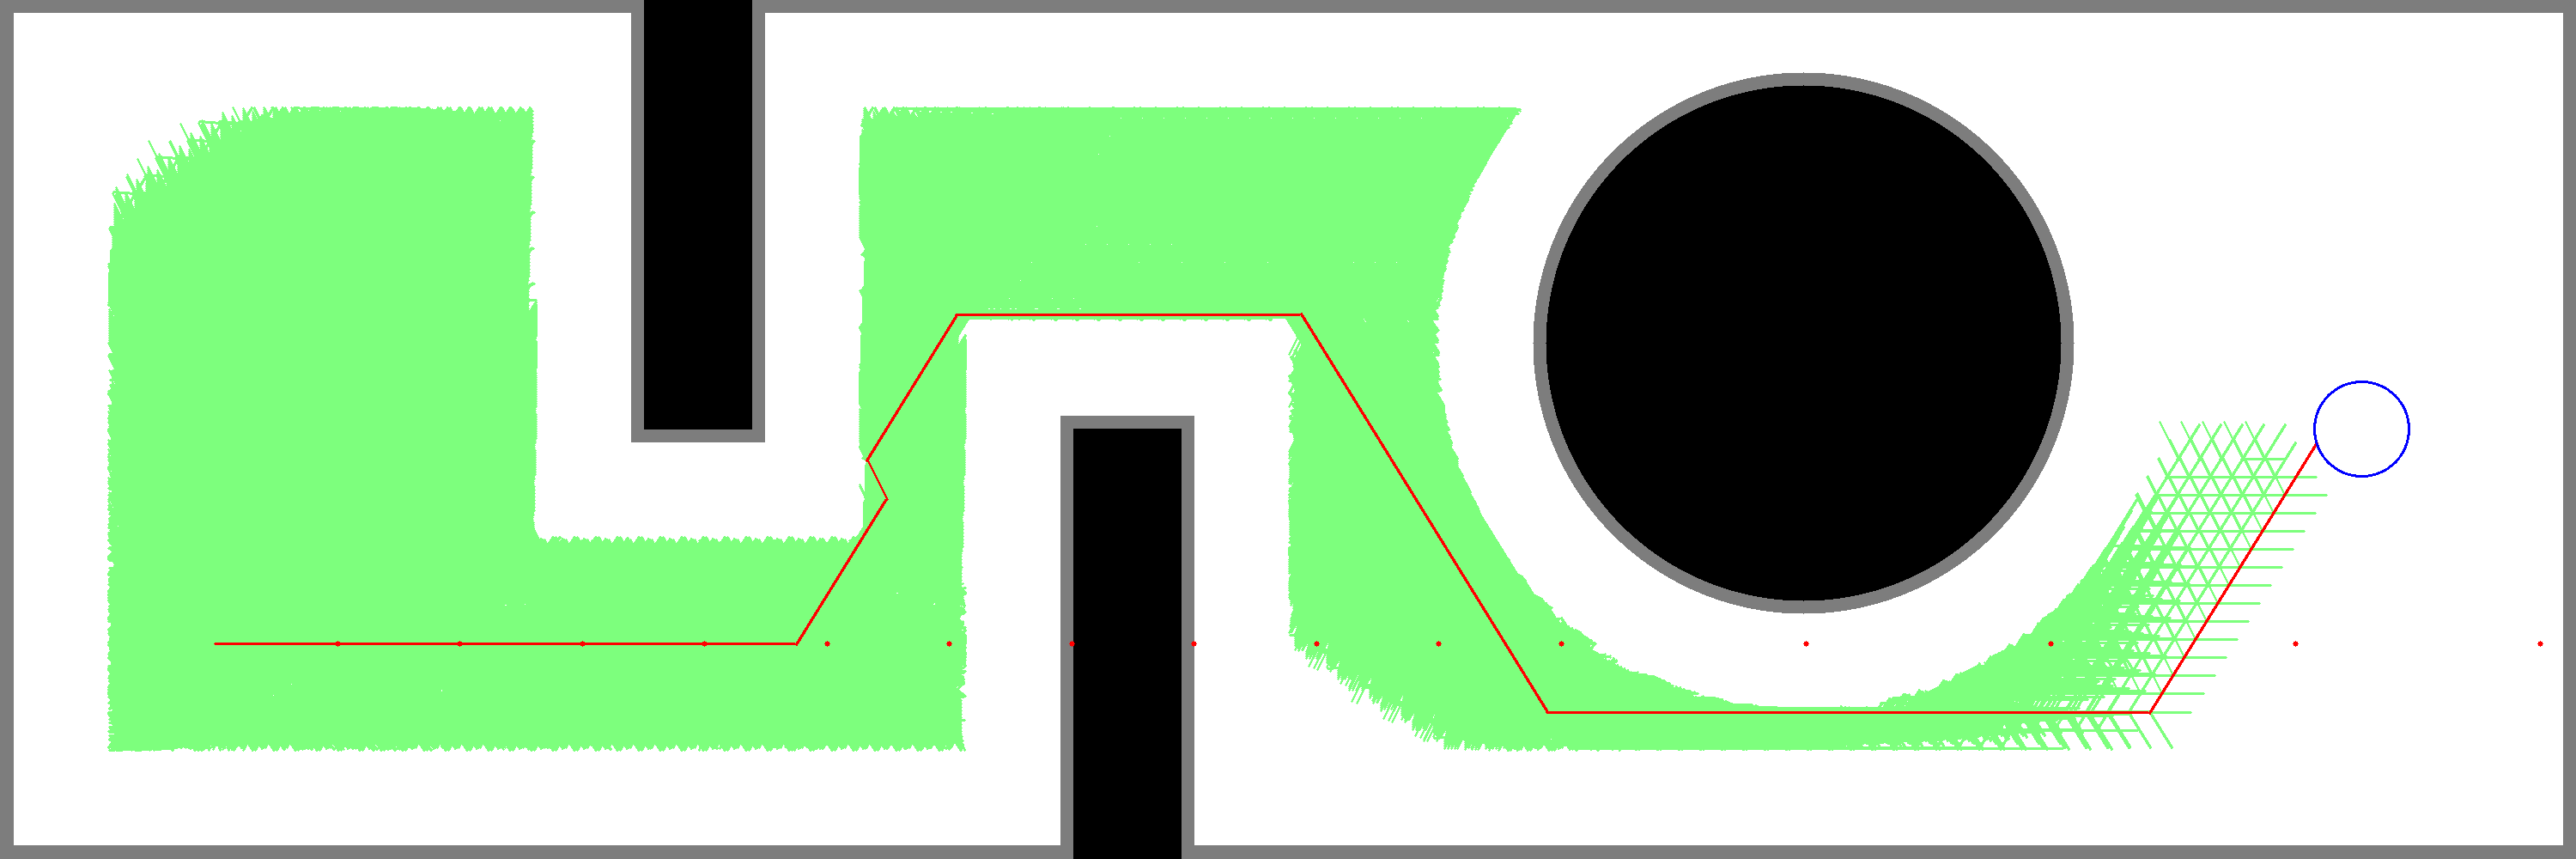

In [100]:
path = []
path_action = []
if not last_explored == -1:
  index = last_explored
else:
  index = last_explored_speed
last = 0
while backtrack_grid[index] > 0:
    x_pos = int(index % width)
    y_pos = int((index - (index % width))/width)

    # path.append((x_pos / scale, y_pos / scale))
    path.append((x_pos, y_pos))
    path_action.append(actions[backtrack_action[index]])
    # print(x_pos, y_pos)
    # print(((x_pos - goal_x)**2 + (y_pos - goal_y)**2)**0.5)

    index = backtrack_grid[index]
path.append((starting_x, starting_y))
path.reverse()
path_action.reverse()

grid_i, gray = createGrid(height, width, obstacle_bounding_boxes, math.ceil(unscaled_clearance * scale), math.ceil(unscaled_clearance * scale), 0, scale)

# gray = grid.copy()
# gray = gray.reshape((height, width))
image = gray.copy()
# image = np.full((height, width, 3), (224, 224, 224))
# image[gray == 125] = (125, 125, 125)
# image[gray == 0] = (0, 0, 0)
# image = np.ascontiguousarray(image, dtype=np.uint8)

visited_length = len(visited)

for i in range(0, visited_length, 2):
  cv2.line(image, visited[i], visited[i+1], (125, 255, 125), 2)


# for point in path:
#   cv2.circle(image, point, 2, (255, 0, 0), -1)



def plot_curve(X0, Y0, Theta0, RPM_L, RPM_R):
    time_run = 1
    r = wheel_radius * scale
    L = wheel_dist * scale
    t = 0
    dt=0.1
    new_x = X0
    new_y = Y0
    theta_new = math.pi * Theta0 / 180
    #calculate right and left wheel velocities using RPM
    ul = RPM_L
    ur = RPM_R
    steps = []
    while t < time_run:
        t = t + dt
        X0 = new_x
        Y0 = new_y
        new_x += (r/2) * (ul+ur) * math.cos(theta_new) * dt
        new_y += (r/2) * (ul+ur) * math.sin(theta_new) * dt
        theta_new += (r / L) * (ur - ul) * dt
        steps.append((round(new_x), round(new_y)))

    new_final_orientation = 180 * (theta_new) / 3.14
    return new_x, new_y, new_final_orientation, steps

last = -1
for point in path:
    if last == -1:
        last = point
    else:
        cv2.line(image, last, point, (0, 0, 255), 2)
        last = point

x = starting_x
y = starting_y
theta = starting_theta
for action in path_action:
  x, y, theta, steps = plot_curve(x, y, theta, action[0], action[1])
  for step in steps:
    cv2.circle(image, step, 3, (0, 0, 255), -1)



cv2.circle(image, (goal_x, goal_y), int(goal_threshold), (255, 0, 0), 2)
image = cv2.flip(image, 0)
image = np.uint8(image)

cv2_imshow(image)

In [102]:
path

[(250, 250),
 (275, 250),
 (325, 250),
 (375, 250),
 (425, 250),
 (475, 250),
 (525, 250),
 (575, 250),
 (625, 250),
 (675, 250),
 (725, 250),
 (775, 250),
 (825, 250),
 (875, 250),
 (925, 250),
 (927, 249),
 (953, 291),
 (979, 333),
 (1005, 375),
 (1031, 417),
 (1033, 418),
 (1011, 462),
 (1009, 463),
 (1035, 505),
 (1061, 547),
 (1087, 589),
 (1113, 631),
 (1113, 633),
 (1163, 633),
 (1213, 633),
 (1263, 633),
 (1313, 633),
 (1363, 633),
 (1413, 633),
 (1463, 633),
 (1513, 633),
 (1515, 634),
 (1541, 592),
 (1567, 550),
 (1593, 508),
 (1619, 466),
 (1645, 424),
 (1671, 382),
 (1697, 340),
 (1723, 298),
 (1749, 256),
 (1775, 214),
 (1801, 172),
 (1801, 170),
 (1851, 170),
 (1901, 170),
 (1951, 170),
 (2001, 170),
 (2051, 170),
 (2101, 170),
 (2151, 170),
 (2201, 170),
 (2251, 170),
 (2301, 170),
 (2351, 170),
 (2401, 170),
 (2451, 170),
 (2501, 170),
 (2503, 169),
 (2516, 190),
 (2542, 232),
 (2568, 274),
 (2594, 316),
 (2620, 358),
 (2646, 400),
 (2672, 442),
 (2698, 484)]

# Graph Generation

each node needs a C2C, C2G, parent and total cost

priority queue??? is open list for sure

a grid to store all 4 values,



divide the search tree based on threshold, then multiply points found by 2 -> only graph generation maybe


follwo medium, dict for graph with costs

separate dict with graph name : location

In [ ]:
time_run = 1
r = 33
L = 280
t = 0
dt=0.1
new_x = starting_x
new_y = starting_y
theta_new = 0
#calculate right and left wheel velocities using RPM
ul = r*0*0.10472
ur = r*700*0.10472
while t < time_run:
    t = t + dt
    X0 = new_x
    Y0 = new_y

    new_x += (r/2) * (ul+ur) * math.cos(theta_new) * dt
    new_y += (r/2) * (ul+ur) * math.sin(theta_new) * dt
    theta_new += (r / L) * (ur - ul) * dt


    print(new_x, new_y)

4491.4028 500.0
610.3449058818164 -432.0332259907739
4166.4691946021385 1380.4999061260498
1131.901212422687 -1212.3158361470435
3477.1277081813696 2017.4223878332357
1950.9132983359618 -1670.6619234357015
2573.729257950335 2271.8495340362315
2888.748046725299 -1707.1025232982865
1653.3123049277688 2088.2887397649865
3740.8561632397186 -1313.689648095804
916.6271823389916 1506.7760892050915
